In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
  print(f"Cuda is available.")

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Change the runtime type before going forward. ')
  

Cuda is available.


Imports

In [ ]:
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as torchfunctional
import torch.optim as torchoptim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

Loading Dataset

In [ ]:
# p(mbar), atmospheric pressure
# T (degC), air temperature
# rh (%), relative humidity
# wv(m/s), wind velocity

train_link="/content/weather_train.csv"
test_link="/content/weather_test.csv"

weather_train = pd.read_csv(train_link)
weather_test = pd.read_csv(test_link)

date_time_train = pd.to_datetime(weather_train.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
date_time_test  = pd.to_datetime(weather_test.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

print("Example of how the train data looks like:")
#print(weather_train.head())
#print(weather_train.shape)
print(weather_train.describe().transpose())
print("\n Size of trian data:")
print(weather_train.shape)

print("\nExample of how the test data looks like:")
print(weather_test.describe().transpose())

print("\n Size of test data")
print(weather_test.shape)


Example of how the train data looks like:
                   count         mean        std      min        25%  \
p (mbar)         56072.0   988.832928   8.350194   913.60   983.8100   
T (degC)         56072.0     8.987746   8.440986   -22.76     2.8800   
Tpot (K)         56072.0   283.059875   8.518036   250.85   277.0000   
Tdew (degC)      56072.0     4.551409   6.830787   -24.80    -0.1200   
rh (%)           56072.0    76.208224  16.498261    13.88    65.4975   
VPmax (mbar)     56072.0    13.170791   7.479040     0.97     7.5200   
VPact (mbar)     56072.0     9.297106   4.150333     0.81     6.0500   
VPdef (mbar)     56072.0     3.873606   4.673326     0.00     0.8200   
sh (g/kg)        56072.0     5.874655   2.634644     0.51     3.8200   
H2OC (mmol/mol)  56072.0     9.404474   4.201705     0.81     6.1200   
rho (g/m**3)     56072.0  1217.704076  40.129584  1059.45  1189.0900   
wv (m/s)         56072.0     2.149853   1.542047     0.00     1.0100   
max. wv (m/s)    56072

Visualizing the relationship between diffrent features in the dataset:

Train data heatmap:


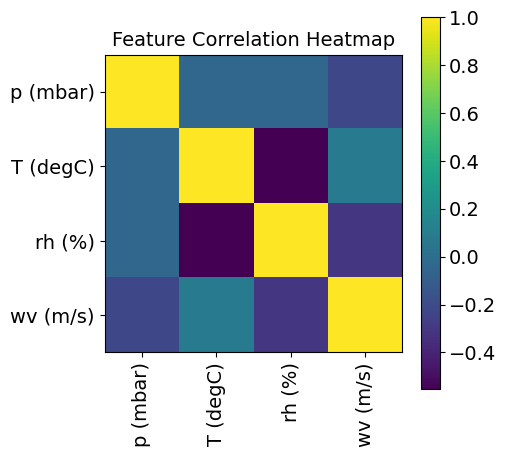

Test data heatmap:


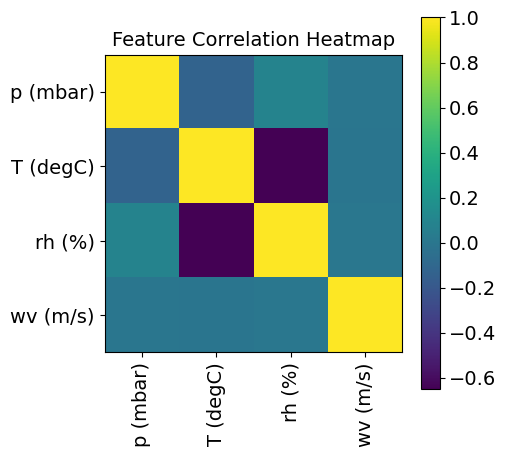

In [ ]:
def show_heatmap(data):
    # Select the columns of interest
    data = data[['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)']]
    
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()

print("Train data heatmap:")
show_heatmap(weather_train)

print("Test data heatmap:")
show_heatmap(weather_test)


Data Pre-processing

In [ ]:
#DO NOT RUN THIS BLOCK, TO BE DELETED!

#Setting negative wind values to 0 instead of their negative value.



wv = weather_test.loc[:, ['wv (m/s)']]
wv_correct = weather_test['wv (m/s)'] < 0
wv[wv_correct]  = 0

maxwv = weather_test.loc[:, ['max. wv (m/s)']]
maxwv_correct = weather_test['max. wv (m/s)'] < 0
maxwv[maxwv_correct] = 0

weather_test['wv (m/s)'] = wv
weather_test['max. wv (m/s)'] = maxwv

In [ ]:
#normalizing the data

weather_train_mean = weather_train.mean()
weather_train_std_dev = weather_train.std()

train_df = (weather_train - weather_train_mean) / weather_train_std_dev
test_df = (weather_test - weather_train_mean) / weather_train_std_dev

print("Pre processed train data:")
print(train_df.describe().transpose())

print("\n Pre-processed test data:")
test_df.describe().transpose()



Pre processed train data:
                   count          mean  std       min       25%       50%  \
p (mbar)         56072.0 -7.546412e-15  1.0 -9.009722 -0.601534  0.048750   
T (degC)         56072.0 -1.338160e-16  1.0 -3.761142 -0.723582 -0.002102   
Tpot (K)         56072.0  3.513684e-15  1.0 -3.781373 -0.711417  0.004711   
Tdew (degC)      56072.0  4.460534e-17  1.0 -4.296930 -0.683876  0.028341   
rh (%)           56072.0 -1.277335e-16  1.0 -3.777866 -0.649203  0.199523   
VPmax (mbar)     56072.0 -2.838521e-16  1.0 -1.631331 -0.755550 -0.227408   
VPact (mbar)     56072.0  4.460534e-17  1.0 -2.044922 -0.782372 -0.173988   
VPdef (mbar)     56072.0  4.055031e-18  1.0 -0.828875 -0.653412 -0.381657   
sh (g/kg)        56072.0 -9.529322e-17  1.0 -2.036197 -0.779861 -0.176364   
H2OC (mmol/mol)  56072.0 -2.331643e-16  1.0 -2.045473 -0.781700 -0.172424   
rho (g/m**3)     56072.0 -4.967412e-15  1.0 -3.943576 -0.713042 -0.071121   
wv (m/s)         56072.0  1.834901e-16  1.0 -1.394

,count,mean,std,min,25%,50%,75%,max
p (mbar),14019.0,0.227476,0.984423,-3.817029,-0.350043,0.254733,0.853522,3.168438
T (degC),14019.0,0.274085,0.958717,-2.684254,-0.462949,0.246684,0.953947,3.351771
Tpot (K),14019.0,0.254276,0.965596,-2.806970,-0.464881,0.221897,0.935676,3.304767
Tdew (degC),14019.0,0.296480,0.885102,-2.906167,-0.369124,0.329185,0.995287,2.229405
rh (%),14019.0,-0.060135,0.991484,-3.186289,-0.724817,0.126788,0.763218,1.436017
VPmax (mbar),14019.0,0.271266,1.138441,-1.477568,-0.587748,0.003905,0.840911,6.765468
VPact (mbar),14019.0,0.285337,1.007746,-1.794339,-0.534200,0.142855,1.000617,3.325732
VPdef (mbar),14019.0,0.180729,1.211398,-0.826736,-0.595637,-0.272527,0.469985,9.016361
sh (g/kg),14019.0,0.280677,1.008817,-1.793280,-0.540739,0.134874,0.992675,3.372503
H2OC (mmol/mol),14019.0,0.280778,1.008079,-1.800334,-0.541322,0.136974,0.991389,3.357096




```
# This is formatted as code
```

Applying a forrier transform on the notable features. This is to expose any periodic charecteristcs in the dataset- which is likley as it is weather data.

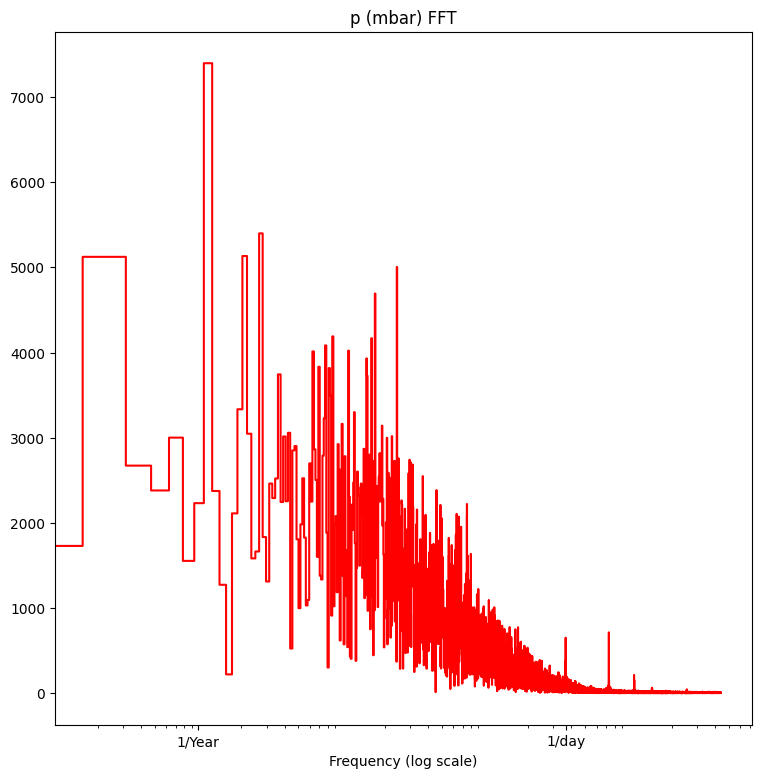

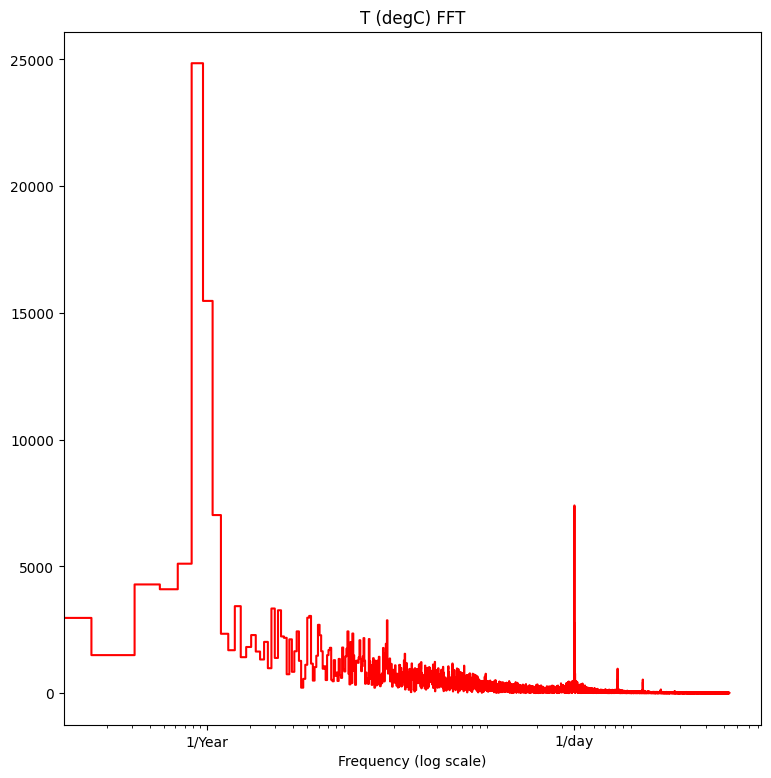

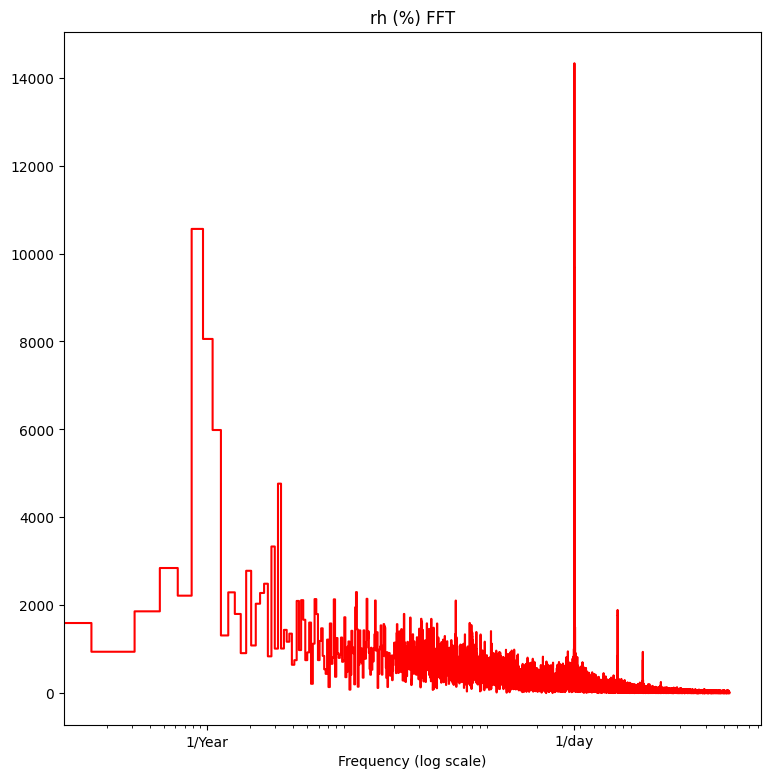

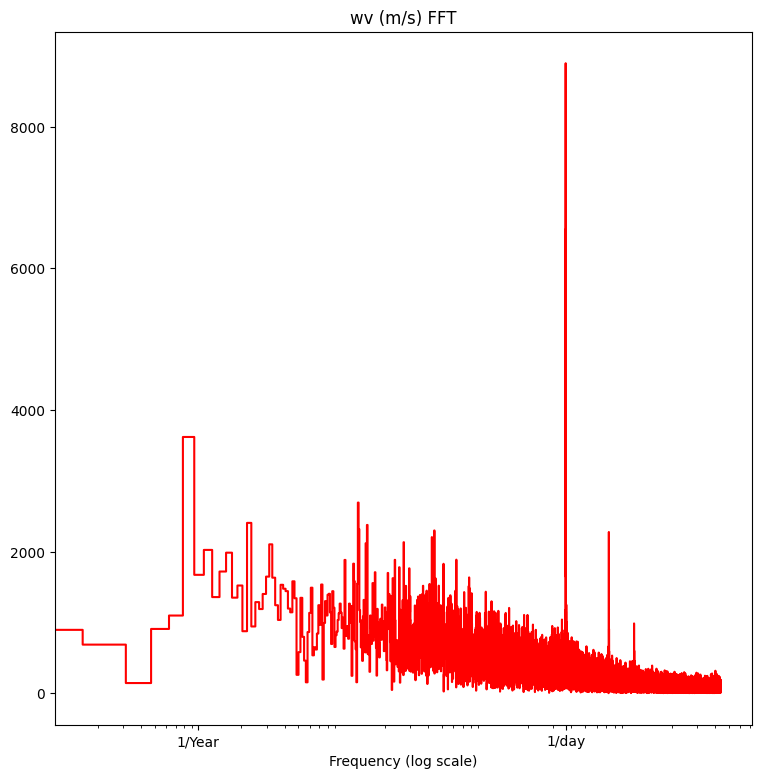

In [ ]:
plt.rcParams['figure.figsize'] = [9, 9] # figure [width, height]


for df_index in ['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)']:  # plot only the 4 features from the report
  fft = scipy.fft.rfft(train_df[df_index].to_numpy())
  f_per_dataset = np.arange(0, len(fft))
  n_samples_h = len(train_df[df_index])
  hours_per_year = 24*365.2524
  years_per_dataset = n_samples_h/(hours_per_year)
  f_per_year = f_per_dataset/years_per_dataset

  fig, fftax = plt.subplots()
  fftax.step(f_per_year, np.abs(fft), color='red')
  fftax.set_xscale('log')
  fftax.set_xlim([0.1, max(plt.xlim())])
  plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
  fftax.set_xlabel('Frequency (log scale)')
  fftax.set_title(df_index + ' FFT')

plt.show()

Our Model: 3 layer 1D CNN fllowed by a 2 layer FCNN. This utilizes both hard and soft parameter sharing.

In [ ]:
class Formulated_Model(nn.Module):
  def __init__(self, input_size, hidden_sizes, num_classes):
    super(Formulated_Model, self).__init__()
    
    self.input_size = input_size
    self.hidden_sizes = hidden_sizes
    self.num_classes = num_classes
    
    self.onedcnn1 = nn.Conv1d(self.input_size, self.hidden_sizes[0], kernel_size=3, padding=1)
    self.onedcnn2 = nn.Conv1d(self.hidden_sizes[0], self.hidden_sizes[1], kernel_size=3, padding=1)
    self.onedcnn3 = nn.Conv1d(self.hidden_sizes[0], self.hidden_sizes[1], kernel_size=3, padding=1)
    self.fcnn1 = nn.Linear(self.hidden_sizes[1], self.num_classes)
    self.fcnn2= nn.Linear(self.hidden_sizes[1], self.num_classes)
    

  def forward(self, data):
    # change the order of the axes in the input tensor so that it matches the expected input shape for the 1D convolutional layers 
    data = torch.swapaxes(data, 1, 2)
   
    s = torchfunctional.relu(self.onedcnn1(data))
    s = torchfunctional.relu(self.onedcnn2(s))
    s= torchfunctional.relu(self.onedcnn3(s))

   # change the order of the axes in the input tensor so that it matches the expected input shape for the fcnn 
    s = torch.swapaxes(s, 1, 2)
    s = self.fcnn1(s)
    output=self.fcnn2(s)
    return torch.squeeze(output[:,-1,:], dim =0)

    

In [ ]:
def Sliding_windows(data, seq_length, feature_columns = None, label_columns=None):
  """ takies data and seq_length (k) to produce feature and label with interest_columns """

  feature = []
  label = []

  ## select attributes in feature_columns we are interested in for training
  if feature_columns is not None:
    data_feature = data[feature_columns]
  else: data_feature = data

  ## select attributes in label_columns we are interested in for predicting
  if label_columns is not None:
      data_label = data[label_columns]
  else: data_label = data

  for i in range(len(data)-seq_length-1):

    feature_element = data_feature.iloc[i:(i+seq_length),:]
    label_element = data_label.iloc[(i+seq_length),:]

    feature.append(feature_element)
    label.append(label_element)

  feature = torch.Tensor(np.array(feature)).to(device)
  label = torch.Tensor(np.array(label)).to(device)

  return feature, label

In [ ]:
# creating train features and corresponding labels.


feature_columns = ['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)']
print('Input features:', feature_columns)

label_columns = ['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)']
print('Labels:', label_columns)

#CHANGE THESE PARAMETERS!!!!
k = 7
batch_size = 50

# create training feature and label
train_feature, train_label = Sliding_windows(train_df, seq_length=k, feature_columns=feature_columns, label_columns=label_columns)
train_feature = DataLoader(train_feature, batch_size=batch_size, shuffle=False, drop_last=True)
train_label = DataLoader(train_label, batch_size=batch_size, shuffle=False, drop_last=True)

# create test feature and label
test_feature, test_label = Sliding_windows(test_df, seq_length=k, feature_columns=feature_columns, label_columns=label_columns)
test_feature = DataLoader(test_feature, batch_size=batch_size, shuffle=False, drop_last=True)
test_label = DataLoader(test_label, batch_size=batch_size, shuffle=False, drop_last=True)


Input features: ['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)']
Labels: ['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)']


In [ ]:
#import torch.optim as torchoptim


# training 
def Training(model, train_feature= train_feature, train_label = train_label):
  # start training
  model.train()  
  epoch_train_loss = 0
  for train_feature_batch, train_label_batch in zip(train_feature, train_label):we pu
    outputs = model(train_feature_batch)
    optimizer.zero_grad()

    # if not Error propagation, squeezing from size (batch_size, 1, k) to (batch_size, k) 
    # train_label_batch = torch.squeeze(train_label_batch)

    # obtain the loss function
    loss = criterion(outputs, train_label_batch)
    loss.backward()
    optimizer.step()
    epoch_train_loss += loss.item()
  return epoch_train_loss/ len(train_feature)
  
     

# testing
def Testing(model, test_feature = test_feature, test_label = test_label):
  # start testing
  model.eval()
  epoch_test_loss = 0
  predict = []
  label = []
  with torch.no_grad():
    for test_feature_batch, test_label_batch in zip(test_feature, test_label):
      test_predict = model(test_feature_batch)

      # if not Error propagation, squeezing from size (batch_size, 1, k) to (batch_size, k) 
      # test_label_batch = torch.squeeze(test_label_batch)
      
      # obtain the loss function
      loss = criterion(test_predict, test_label_batch)
      predict.append(test_predict)
      label.append(test_label_batch)
      epoch_test_loss += loss.item()
  return epoch_test_loss / len(test_feature), predict, label

